In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import CartesianRepresentation, UnitSphericalRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix

In [2]:
from scipy.integrate import quad 

def limb_darkening(u_ld, r):
    u1, u2 = u_ld
    mu = np.sqrt(1 - r**2)
    return (1 - u1 * (1 - mu) - u2 * (1 - mu)**2) / (1 - u1/3 - u2/6) / np.pi

def limb_darkening_normed(u_ld, r): 
    return limb_darkening(u_ld, r)/limb_darkening(u_ld, 0)

def total_flux(u_ld): 
    return 2 * np.pi * quad(lambda r: r * limb_darkening_normed(u_ld, r), 0, 1)[0]

spot_contrast = 0.7
u_ld = [0.5079, 0.2239]
f0 = total_flux(u_ld)

In [26]:
n_rotations = 30
angles = np.arange(0, 2*np.pi, 2*np.pi/n_rotations) * u.rad
transform_matrix = rotation_matrix(angles[:, np.newaxis])

In [39]:
inc_stellar = 90 * u.deg

r_spot = np.array([0.2, 0.2])

spot_lats = np.array([[0, 80]])*u.deg
spot_lons = np.array([[0, 180]])*u.deg

usr = UnitSphericalRepresentation(spot_lons * np.ones((n_rotations, len(spot_lats))), 
                                  spot_lats * np.ones((n_rotations, len(spot_lats)))) 
cartesian = usr.represent_as(CartesianRepresentation)

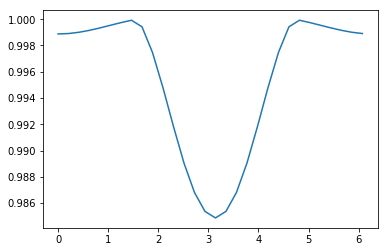

In [41]:
rotated_spot_positions = cartesian.transform(transform_matrix)
r = np.ma.masked_array(np.sqrt(rotated_spot_positions.y**2 + rotated_spot_positions.z**2), 
                       mask=rotated_spot_positions.x > 0)
ld = limb_darkening_normed(u_ld, r)

f_spots = np.pi * r_spot**2 * (1 - spot_contrast) * ld * np.sqrt(1 - r**2)

delta_f = 1 - np.sum(f_spots/f0, axis=-1)
plt.plot(angles, delta_f.data)